## Обучение ML модели для выделения трущобной застройки

In [467]:
import geopandas as gpd
import pandas as pd
import folium
import numpy as np
from shapely.geometry import box
import rasterio
import rasterio.features
from rasterio.enums import Resampling
from rasterio.windows import Window
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import os
import osmnx as ox
from shapely.geometry import box
from skimage.feature import graycomatrix
from skimage.util import view_as_windows
import dask.array as da
from dask.diagnostics import ProgressBar
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
import joblib

### Открываем границы `Мумбаи` и домики, обрезанные по маске Мумбаи, здания выгружены с [microsoft](https://github.com/microsoft/GlobalMLBuildingFootprints/tree/main). По Индии там данные за конец 2023 года.

In [510]:
mumbai = gpd.read_file('Границы/mumbai_boundary.gpkg')
mumbai_builds_clipped = gpd.read_file('Домики/mumbai_builds_clipped.geojson')
max_lat_first = mumbai_builds_clipped[122979:122981].geometry.bounds['maxy'].max()
second_bounds = mumbai_builds_clipped.geometry.bounds
mumbai_builds_clipped = mumbai_builds_clipped[second_bounds['maxy'] <= max_lat_first].copy()
mumbai_builds_all_clipped = gpd.read_file('Домики/mumbai_builds_all_clipped.geojson')
mumbai_wards = gpd.read_file('Границы/mumbai_wards.geojson')

### Визуализация на примере индекса NDBI по тайлам 250 на 250 м.

C:\Users\Mariia\AppData\Local\Temp\ipykernel_30980\2637201089.py:22: RuntimeWarning: invalid value encountered in divide
  ndbi = np.where(sum_band != 0, (swir - nir) / sum_band, np.nan)


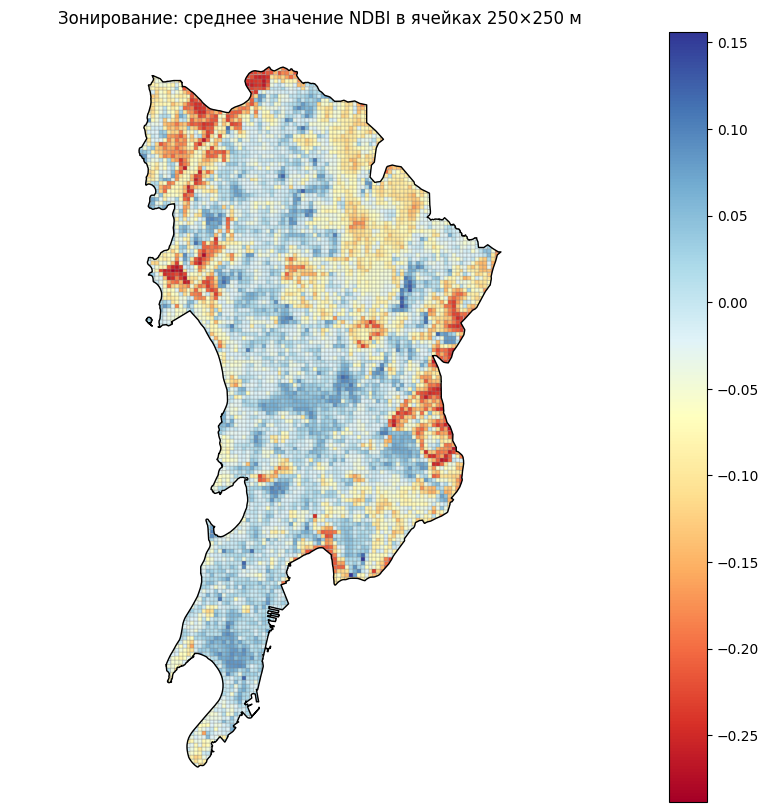

In [7]:
mumbai_metric = mumbai.to_crs(epsg=3857)
minx, miny, maxx, maxy = mumbai_metric.total_bounds
cell_size = 250

x_coords = np.arange(minx, maxx + cell_size, cell_size)
y_coords = np.arange(miny, maxy + cell_size, cell_size)

polygons = []
for x0 in x_coords[:-1]:
    for y0 in y_coords[:-1]:
        polygons.append(box(x0, y0, x0 + cell_size, y0 + cell_size))

grid = gpd.GeoDataFrame({'geometry': polygons}, crs=mumbai_metric.crs)
grid_clipped = gpd.overlay(grid, mumbai_metric, how='intersection')

# Открываем растр и вычисляем NDBI
raster_path = 'снимки/cropped/Mumbai_Sentinel-2_cr.tif'
with rasterio.open(raster_path) as src:
    nir = src.read(4).astype('float32')
    swir = src.read(5).astype('float32')
    sum_band = swir + nir
    ndbi = np.where(sum_band != 0, (swir - nir) / sum_band, np.nan)
    raster_transform = src.transform
    raster_crs = src.crs
    raster_height = src.height
    raster_width = src.width

grid_raster_crs = grid_clipped.to_crs(raster_crs)

# Для каждой ячейки считаем среднее значение NDBI
mean_ndbi = []
for geom in grid_raster_crs.geometry:
    mask = rasterio.features.geometry_mask(
        [geom],
        invert=True,
        transform=raster_transform,
        out_shape=(raster_height, raster_width)
    )
    cell_values = ndbi[mask]
    if cell_values.size > 0:
        mean_ndbi.append(np.nanmean(cell_values))
    else:
        mean_ndbi.append(np.nan)

grid_clipped['mean_ndbi'] = mean_ndbi

fig, ax = plt.subplots(figsize=(10, 10))
grid_clipped.plot(
    column='mean_ndbi',
    cmap='RdYlBu',
    legend=True,
    edgecolor='grey',
    linewidth=0.2,
    ax=ax,
    missing_kwds={'color': 'lightgrey'}
)
mumbai_metric.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
ax.set_title('Зонирование: среднее значение NDBI в ячейках 250×250 м')
ax.axis('equal')
ax.axis('off')
plt.show()

### Делаем датасет с индексами и тематическими продуктами дистанционного зондирования, рассчитанные на каждый тайл 250 на 250 м
- NDVI
- NDBI
- GLCM
- IBI
- NightLights

In [29]:
# ----------  ПАРАМЕТРЫ  ----------
tif_path   = 'снимки/cropped/Mumbai_Sentinel-2_cr.tif'
red_idx    = 3
green_idx  = 2
nir_idx    = 4
swir_idx   = 5
eps        = np.finfo('float32').eps

with rasterio.open(tif_path) as src:
    red   = src.read(red_idx,  out_dtype='float32', masked=True).filled(np.nan)
    green = src.read(green_idx,out_dtype='float32', masked=True).filled(np.nan)
    nir   = src.read(nir_idx,  out_dtype='float32', masked=True).filled(np.nan)
    swir  = src.read(swir_idx, out_dtype='float32', masked=True).filled(np.nan)
    profile = src.profile

# ----------  СПЕКТРАЛЬНЫЕ ИНДЕКСЫ ndbi  = (swir - nir)  / (swir + nir  + eps) ----------
ndvi  = (nir  - red)  / (nir  + red  + eps)
mndwi = (green - swir)/(green + swir + eps)

ibi_num = ndbi - (ndvi + mndwi)/2
ibi_den = ndbi + (ndvi + mndwi)/2 + eps
ibi = ibi_num / ibi_den
ibi = np.clip(ibi, -1, 1) ----------


# ----------  СОХРАНЕНИЕ  ----------
def save_tif(arr, out_name):
    profile_upd = profile.copy()
    profile_upd.update(count=1, dtype='float32', nodata=np.nan)
    with rasterio.open(out_name, 'w', **profile_upd) as dst:
        dst.write(arr.astype('float32'), 1)

save_tif(ibi,'снимки/cropped/Mumbai_IBI.tif')

In [25]:
# ---------------------------------------------------
# ПАРАМЕТРЫ
# ---------------------------------------------------
tif_path = "снимки/cropped/Mumbai_Sentinel-2_cr.tif"
nir_idx  = 4
win      = 7       # размер окна GLCM (должен быть нечетным)
levels   = 16      # число уровней квантования (например, 16)
eps      = 1e-12

pad = win // 2

chunk_size = (2048, 2048)


with rasterio.open(tif_path) as src:
    nir_full = src.read(nir_idx, out_dtype="float32", masked=True).filled(np.nan)
    profile  = src.profile

da_nir = da.from_array(nir_full, chunks=chunk_size)

nir_min = da_nir.min().compute()
nir_max = da_nir.max().compute()


da_q = ((da_nir - nir_min) / (nir_max - nir_min + eps) * (levels - 1))\
        .map_blocks(lambda x: np.floor(x).astype(np.uint8),
                    dtype=np.uint8)

def glcm_entropy_block(block: np.ndarray) -> np.ndarray:
    rows_full, cols_full = block.shape
    rows_out = rows_full - 2 * pad
    cols_out = cols_full - 2 * pad

    out = np.empty((rows_out, cols_out), dtype=np.float32)

    for i in range(pad, rows_full - pad):
        for j in range(pad, cols_full - pad):
            w = block[i - pad : i + pad + 1, j - pad : j + pad + 1]

            G = np.zeros((levels, levels), dtype=np.float32)
            for r in range(win):
                for c in range(win - 1):
                    p = int(w[r, c])
                    q = int(w[r, c + 1])
                    G[p, q] += 1.0
                    G[q, p] += 1.0

            total = G.sum()
            if total > 0:
                G /= total
                h = 0.0
                nz = G > 0
                h = -np.sum(G[nz] * np.log2(G[nz] + eps))
                out[i - pad, j - pad] = h
            else:
                out[i - pad, j - pad] = np.nan

    return out

da_entropy = da_q.map_overlap(
    glcm_entropy_block,
    depth=(pad, pad),
    boundary="reflect",
    dtype=np.float32
)

with ProgressBar():
    entropy_result = da_entropy.compute()

def save_tif(arr: np.ndarray, out_name: str, ref_profile: dict):
    prof = ref_profile.copy()
    prof.update(count=1, dtype="float32", nodata=np.nan)
    with rasterio.open(out_name, "w", **prof) as dst:
        dst.write(arr.astype("float32"), 1)

with rasterio.open(tif_path) as ref:
    save_tif(entropy_result, "GLCM_entropy_dask.tif", ref.profile)

[########################################] | 100% Completed | 68m 55ss


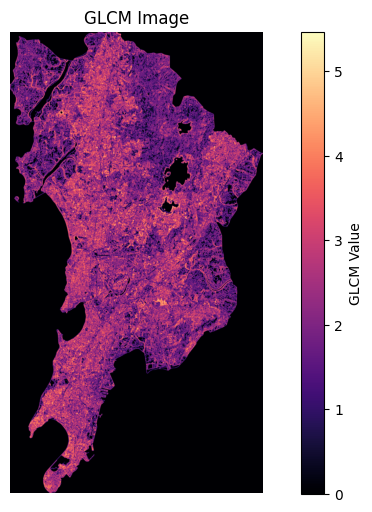

In [26]:
plt.figure(figsize=(10, 6))
plt.imshow(entropy_result, cmap='magma')
plt.colorbar(label='GLCM Value')
plt.title('GLCM Image')
plt.axis('off')
plt.show()

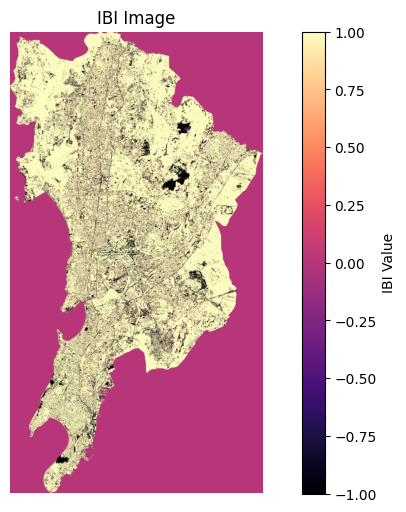

In [27]:
plt.figure(figsize=(10, 6))
plt.imshow(ibi, cmap='magma')
plt.colorbar(label='IBI Value')
plt.title('IBI Image')
plt.axis('off')
plt.show()

In [60]:
mumbai_metric = mumbai.to_crs(epsg=3857)
minx, miny, maxx, maxy = mumbai_metric.total_bounds
cell_size = 250

x_coords = np.arange(minx, maxx + cell_size, cell_size)
y_coords = np.arange(miny, maxy + cell_size, cell_size)

polygons = []
for x0 in x_coords[:-1]:
    for y0 in y_coords[:-1]:
        polygons.append(box(x0, y0, x0 + cell_size, y0 + cell_size))

grid = gpd.GeoDataFrame({'geometry': polygons}, crs=mumbai_metric.crs)
grid['tile_id'] = range(len(grid))

grid_clipped = gpd.overlay(grid, mumbai_metric, how='intersection')

# ---------------------------------------------------
# Открываем растровый файл Sentinel-2 и вычисляем NDVI, NDBI
# ---------------------------------------------------
raster_path = 'снимки/cropped/Mumbai_Sentinel-2_cr.tif'
with rasterio.open(raster_path) as src:
    # Предполагается порядок: band1: Blue, band2: Green, band3: Red, band4: NIR, band5: SWIR
    blue = src.read(1).astype('float32')
    green = src.read(2).astype('float32')
    red = src.read(3).astype('float32')
    nir = src.read(4).astype('float32')
    swir = src.read(5).astype('float32')
    raster_transform = src.transform
    raster_crs = src.crs
    raster_height = src.height
    raster_width = src.width

# Вычисляем векторы индексов
ndvi_raster = np.where((nir + red) != 0, (nir - red) / (nir + red), np.nan)
ndbi_raster = np.where((swir + nir) != 0, (swir - nir) / (swir + nir), np.nan)

grid_raster_crs = grid_clipped.to_crs(raster_crs)

# ---------------------------------------------------
# Для каждой ячейки считаем средние значения NDVI, NDBI
# ---------------------------------------------------
mean_ndvi = []
mean_ndbi = []

for geom in grid_raster_crs.geometry:
    mask = rasterio.features.geometry_mask(
        [geom],
        invert=True,
        transform=raster_transform,
        out_shape=(raster_height, raster_width)
    )
    vals_ndvi = ndvi_raster[mask]
    vals_ndbi = ndbi_raster[mask]
    
    mean_ndvi.append(np.nanmean(vals_ndvi) if vals_ndvi.size > 0 else np.nan)
    mean_ndbi.append(np.nanmean(vals_ndbi) if vals_ndbi.size > 0 else np.nan)

# Добавляем колонки в grid_clipped
grid_clipped['mean_ndvi'] = mean_ndvi
grid_clipped['mean_ndbi'] = mean_ndbi

# ---------------------------------------------------
# Открываем растровый файл GLCM-энтропии и вычисляем среднее GLCM по ячейкам
# ---------------------------------------------------
glcm_path = 'снимки/cropped/Mumbai_GLCM_entropy_dask.tif'
with rasterio.open(glcm_path) as src_g:
    glcm_data = src_g.read(1).astype('float32')
    glcm_transform = src_g.transform
    glcm_crs = src_g.crs
    glcm_height = src_g.height
    glcm_width = src_g.width

if glcm_crs != raster_crs:
    grid_glcm_crs = grid_clipped.to_crs(glcm_crs)
else:
    grid_glcm_crs = grid_raster_crs

mean_glcm = []
for geom in grid_glcm_crs.geometry:
    mask = rasterio.features.geometry_mask(
        [geom],
        invert=True,
        transform=glcm_transform,
        out_shape=(glcm_height, glcm_width)
    )
    vals_glcm = glcm_data[mask]
    mean_glcm.append(np.nanmean(vals_glcm) if vals_glcm.size > 0 else np.nan)

grid_clipped['mean_glcm'] = mean_glcm

# ---------------------------------------------------
# Открываем растровый файл ночного освещения и вычисляем среднее
# ---------------------------------------------------
night_path = 'снимки/cropped/Mumbai_NightLights_2024_2025_cr.tif'
with rasterio.open(night_path) as src_n:
    night_data = src_n.read(1).astype('float32')
    night_transform = src_n.transform
    night_crs = src_n.crs
    night_height = src_n.height
    night_width = src_n.width

if night_crs != raster_crs:
    grid_night_crs = grid_clipped.to_crs(night_crs)
else:
    grid_night_crs = grid_raster_crs

mean_night = []
for geom in grid_night_crs.geometry:
    mask = rasterio.features.geometry_mask(
        [geom],
        invert=True,
        transform=night_transform,
        out_shape=(night_height, night_width)
    )
    vals_night = night_data[mask]
    mean_night.append(np.nanmean(vals_night) if vals_night.size > 0 else np.nan)

grid_clipped['mean_nightlights'] = mean_night

# ---------------------------------------------------
# Открываем растровый файл индекса IBI и вычисляем среднее
# ---------------------------------------------------
ibi_path = 'снимки/cropped/Mumbai_IBI.tif'
with rasterio.open(ibi_path) as src_n:
    ibi_data = src_n.read(1).astype('float32')
    ibi_transform = src_n.transform
    ibi_crs = src_n.crs
    ibi_height = src_n.height
    ibi_width = src_n.width

# Приводим сетку, если CRS ночного освещения не совпадает
if ibi_crs != raster_crs:
    grid_ibi_crs = grid_clipped.to_crs(ibi_crs)
else:
    grid_ibi_crs = grid_raster_crs

mean_ibi = []
for geom in grid_ibi_crs.geometry:
    mask = rasterio.features.geometry_mask(
        [geom],
        invert=True,
        transform=ibi_transform,
        out_shape=(ibi_height, ibi_width)
    )
    vals_ibi = ibi_data[mask]
    mean_ibi.append(np.nanmean(vals_ibi) if vals_ibi.size > 0 else np.nan)

grid_clipped['mean_ibi'] = mean_ibi

### Добавляем разметку с площадью трущоб в тайле 250 на 250 м, будем обучаться на задачу регрессии

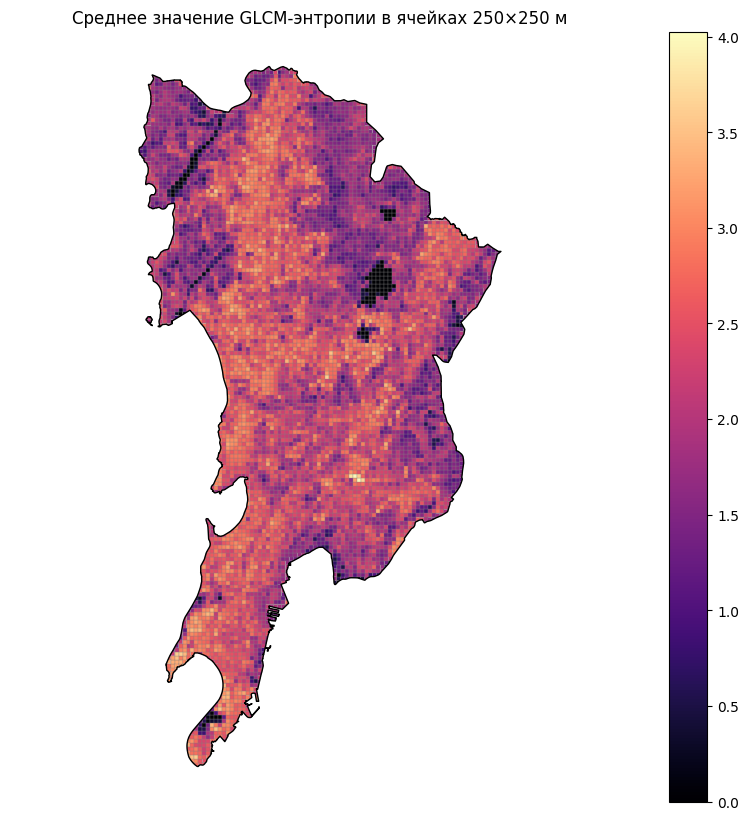

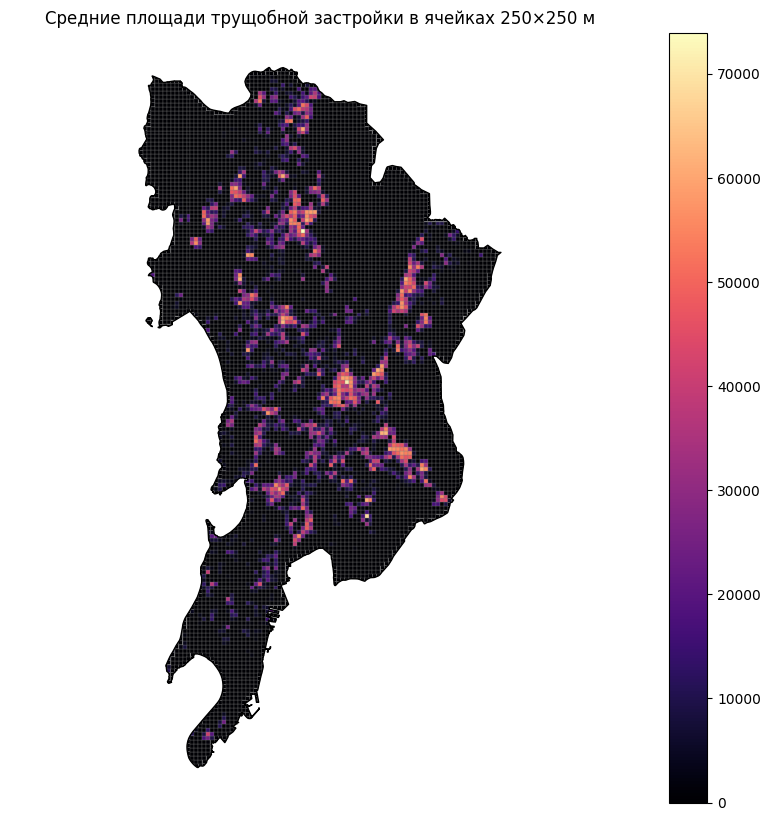

,geometry,mean_ndvi,mean_ndbi,mean_ibi,mean_glcm,mean_nightlights,slum_area_m2
0,"POLYGON ((8101674.331 2180954.992, 8101674.331...",0.173124,0.104725,501.669037,2.529886,1.945000,0.0
1,"POLYGON ((8101674.331 2181204.992, 8101674.331...",0.184896,0.095505,-394.081146,1.562152,1.891250,0.0
2,"POLYGON ((8101674.331 2181454.992, 8101674.331...",0.244440,0.051286,-0.108527,1.009415,2.045961,0.0
3,"POLYGON ((8101674.331 2181704.992, 8101674.331...",0.280680,0.001981,-7.426566,1.354634,2.121068,0.0
4,"POLYGON ((8101674.331 2181704.992, 8101638.544...",0.171637,0.052120,3.714300,2.072296,2.545000,0.0


In [51]:
# ---------------------------------------------------
# Открываем файл полигоны трущоб и считаем площадь пересечения с тайлами
# ---------------------------------------------------
slum_gdf = gpd.read_file("снимки/mumbai_slum_cluster.geojson")
slum_gdf = slum_gdf.to_crs(mumbai_metric.crs)

grid_for_slum = grid_clipped[['tile_id', 'geometry']].copy()
slum_intersect = gpd.overlay(grid_for_slum, slum_gdf, how='intersection')

# Вычисляем площадь «кусочков» пересечения (в единицах CRS EPSG:3857 → м²)
slum_intersect['area_intersection'] = slum_intersect.geometry.area

# Суммируем площади по каждому tile_id
area_per_tile = slum_intersect.groupby('tile_id')['area_intersection'].sum().reset_index()
area_per_tile = area_per_tile.rename(columns={'area_intersection': 'slum_area_m2'})

# Объединяем с grid_clipped
grid_clipped = grid_clipped.set_index('tile_id').join(area_per_tile.set_index('tile_id'))
grid_clipped['slum_area_m2'] = grid_clipped['slum_area_m2'].fillna(0.0)

# ---------------------------------------------------
# Визуализация: отображаем средний GLCM-энтропию по ячейкам
# ---------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 10))
grid_clipped.plot(
    column='mean_glcm',
    cmap='magma',
    legend=True,
    edgecolor='grey',
    linewidth=0.2,
    ax=ax,
    missing_kwds={'color': 'lightgrey'}
)
mumbai_metric.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
ax.set_title('Среднее значение GLCM-энтропии в ячейках 250×250 м')
ax.axis('equal')
ax.axis('off')
plt.show()

# ---------------------------------------------------
# Визуализация: отображаем средние площади трущобной застройки по ячейкам
# ---------------------------------------------------

fig, ax = plt.subplots(figsize=(10, 10))
grid_clipped.plot(
    column='slum_area_m2',
    cmap='magma',
    legend=True,
    edgecolor='grey',
    linewidth=0.2,
    ax=ax,
    missing_kwds={'color': 'lightgrey'}
)
mumbai_metric.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
ax.set_title('Средние площади трущобной застройки в ячейках 250×250 м')
ax.axis('equal')
ax.axis('off')
plt.show()
# ---------------------------------------------------
# Сохраняем результат в файл для дальнейшего обучения
# ---------------------------------------------------
grid_clipped = grid_clipped.reset_index(drop = True)[['geometry', 'mean_ndvi', 'mean_ndbi', 'mean_ibi',
       'mean_glcm', 'mean_nightlights', 'slum_area_m2']]

grid_clipped.to_file("mumbai_aggregated_tiles.geojson", driver="GeoJSON", encoding="utf-8")

grid_clipped.head()


### Попробуем обучиться только на индексах и тематических прродуктах. Используем Random Forest

RMSE на тестовой выборке: 7641.97
R^2 на тестовой выборке: 0.50


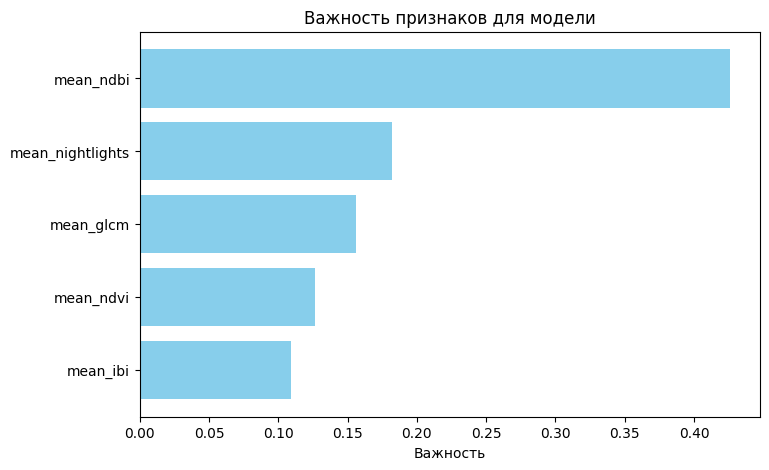

In [303]:
gdf = grid_clipped.copy()
df = pd.DataFrame(gdf.drop(columns="geometry"))
feature_cols = ["mean_ndvi", "mean_ndbi", "mean_ibi", "mean_glcm", "mean_nightlights"]
X = df[feature_cols]
y = df["slum_area_m2"]

imputer = SimpleImputer(strategy="median")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=feature_cols)

X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42
)

model = RandomForestRegressor(n_estimators=300, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE на тестовой выборке: {rmse:.2f}")
print(f"R^2 на тестовой выборке: {r2:.2f}")

# Важность признаков
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    "feature": feature_cols,
    "importance": importances
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(8, 5))
plt.barh(feature_importance_df["feature"], feature_importance_df["importance"], color="skyblue")
plt.xlabel("Важность")
plt.title("Важность признаков для модели")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# joblib.dump(model, "модель/slum_area_model_rf300.pkl")

In [308]:
y_test_cl = (y_test/(250**2)>0.29).astype(int)
y_pred_cl = (y_pred/(250**2)>0.29).astype(int)

# Рассчитываем метрики
accuracy = accuracy_score(y_test_cl, y_pred_cl)
precision = precision_score(y_test_cl, y_pred_cl)
recall = recall_score(y_test_cl, y_pred_cl)
f1 = f1_score(y_test_cl, y_pred_cl)
roc_auc = roc_auc_score(y_test_cl, y_pred_cl)

# Выводим результаты
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')

Accuracy: 0.93
Precision: 0.72
Recall: 0.44
F1 Score: 0.55
ROC AUC: 0.71


### Результаты не очень, добавим статистику по домикам

In [223]:
grid_clipped = grid_clipped[['mean_ndvi', 'mean_ndbi', 'mean_ibi', 'mean_glcm', 'mean_nightlights',
       'slum_area_m2', 'geometry']]

In [225]:
if "tile_id" not in grid_clipped.columns:
    grid_clipped = grid_clipped.reset_index(drop=True)
    grid_clipped["tile_id"] = grid_clipped.index

if mumbai_builds_clipped.crs != grid_clipped.crs:
    mumbai_builds_clipped = mumbai_builds_clipped.to_crs(grid_clipped.crs)

# Рассчитываем полную площадь зданий (в м²)
mumbai_builds_clipped["build_area_m2"] = mumbai_builds_clipped.geometry.area

# Spatial join: какие здания пересекают каждый тайл?
builds_with_tile = gpd.sjoin(
    mumbai_builds_clipped[["geometry", "build_area_m2"]],
    grid_clipped[["tile_id", "geometry"]],
    how="inner",
    predicate="intersects"
).drop(columns="index_right")

# Группировка по tile_id для вычисления статистик
builds_stats = builds_with_tile.groupby("tile_id").agg(
    total_builds_count=("build_area_m2", "count"),
    median_build_area=("build_area_m2", "median"),
    count_small_builds=("build_area_m2", lambda x: np.sum(x <= 40))
).reset_index()

# Добавляем полученные статистики в grid_clipped
grid_clipped = grid_clipped.set_index("tile_id")
builds_stats = builds_stats.set_index("tile_id")

grid_clipped["total_builds_count"] = builds_stats["total_builds_count"].fillna(0).astype(int)
grid_clipped["median_build_area_m2"] = builds_stats["median_build_area"].fillna(0)
grid_clipped["count_small_builds"] = builds_stats["count_small_builds"].fillna(0).astype(int)

# Рассчитываем процент зданий < 40 м²
grid_clipped["pct_builds_less_40m2"] = np.where(
    grid_clipped["total_builds_count"] > 0,
    grid_clipped["count_small_builds"] / grid_clipped["total_builds_count"],
    0.0
)

# Рассчитываем процент площади тайла, занятой зданиями
intersections = gpd.overlay(
    grid_clipped.reset_index()[["tile_id", "geometry"]],
    mumbai_builds_clipped[["geometry"]],
    how="intersection"
)
intersections["intersection_area"] = intersections.geometry.area
area_per_tile = intersections.groupby("tile_id")["intersection_area"].sum().reset_index()

# Добавляем процент занятости тайла
tile_area = 250 * 250
area_per_tile = area_per_tile.set_index("tile_id")
grid_clipped["builds_area_m2"] = area_per_tile["intersection_area"].fillna(0)
grid_clipped["pct_tile_built_area"] = grid_clipped["builds_area_m2"] / tile_area

grid_clipped = grid_clipped.reset_index(drop=False)
grid_clipped.to_file("mumbai_aggregated_tiles_with_builds.geojson", driver="GeoJSON", encoding="utf-8")

grid_clipped.head()

C:\Users\Mariia\AppData\Local\Temp\ipykernel_30980\761037983.py:54: UserWarning:

`keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries



,tile_id,mean_ndvi,mean_ndbi,mean_ibi,mean_glcm,mean_nightlights,slum_area_m2,geometry,total_builds_count,median_build_area_m2,count_small_builds,pct_builds_less_40m2,builds_area_m2,pct_tile_built_area
0,0,0.173124,0.104725,501.669037,2.529886,1.945000,0.0,"POLYGON ((8101674.331 2180954.992, 8101674.331...",NaN,NaN,NaN,0.0,NaN,NaN
1,1,0.184896,0.095505,-394.081146,1.562152,1.891250,0.0,"POLYGON ((8101674.331 2181204.992, 8101674.331...",NaN,NaN,NaN,0.0,NaN,NaN
2,2,0.244440,0.051286,-0.108527,1.009415,2.045961,0.0,"POLYGON ((8101674.331 2181454.992, 8101674.331...",NaN,NaN,NaN,0.0,NaN,NaN
3,3,0.280680,0.001981,-7.426566,1.354634,2.121068,0.0,"POLYGON ((8101674.331 2181704.992, 8101674.331...",NaN,NaN,NaN,0.0,NaN,NaN
4,4,0.171637,0.052120,3.714300,2.072296,2.545000,0.0,"POLYGON ((8101674.331 2181704.992, 8101638.544...",NaN,NaN,NaN,0.0,NaN,NaN


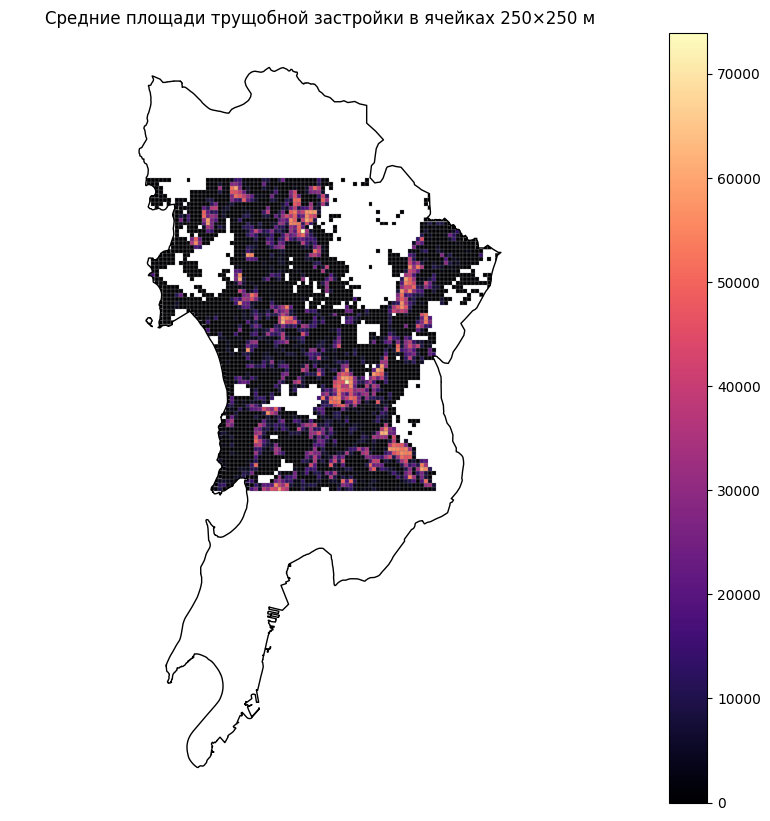

In [267]:
fig, ax = plt.subplots(figsize=(10, 10))
grid_clipped.dropna().plot(
    column='slum_area_m2',
    cmap='magma',
    legend=True,
    edgecolor='grey',
    linewidth=0.2,
    ax=ax,
    missing_kwds={'color': 'lightgrey'}
)
mumbai_metric.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
ax.set_title('Средние площади трущобной застройки в ячейках 250×250 м')
ax.axis('equal')
ax.axis('off')
plt.show()

### Будем обучаться именно на этом куске данных (что на карте выше), так как домиков на Мумбаи с широтами меньше и больше в microsoft нет, а в OSM их мало и у них другая "природа", что окажет влияние на качетсво модели.

Заместим пробелы внутри рассматриваемой области нулями, так как там просто нет домиков. Далее обучим `Random Forest`

RMSE на тестовой выборке: 5812.53
R^2 на тестовой выборке: 0.76


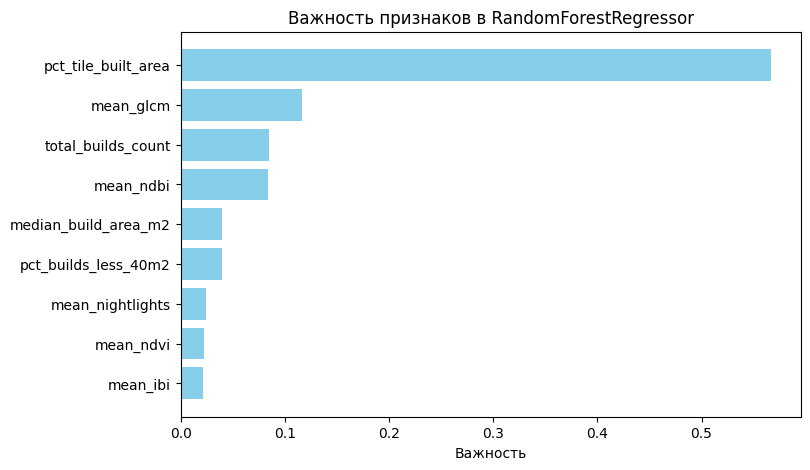

In [457]:
minx, miny, maxx, maxy = grid_clipped.dropna().total_bounds
grid_clipped_bounds = grid_clipped.geometry.bounds

filtered_indices = grid_clipped_bounds[
    (grid_clipped_bounds['miny'] > miny) & 
    (grid_clipped_bounds['maxy'] < maxy)
].index

filtered_grid_clipped = grid_clipped.loc[filtered_indices].copy()

filtered_grid_clipped = filtered_grid_clipped.fillna(0)

gdf = filtered_grid_clipped.copy()

feature_cols = ['mean_ndvi', 'mean_ndbi', 'mean_ibi', 'mean_glcm',
       'mean_nightlights', 'total_builds_count','median_build_area_m2',
                'pct_builds_less_40m2','pct_tile_built_area']

X = gdf[feature_cols]
y = gdf["slum_area_m2"]

imputer = SimpleImputer(strategy="median")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=feature_cols, index=gdf.index)

train_idx, test_idx = train_test_split(
    gdf.index,
    test_size=0.2,
    random_state=42
)

X_train = X_imputed.loc[train_idx]
y_train = y.loc[train_idx]
X_test  = X_imputed.loc[test_idx]
y_test  = y.loc[test_idx]

model = RandomForestRegressor(n_estimators=300, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)
print(f"RMSE на тестовой выборке: {rmse:.2f}")
print(f"R^2 на тестовой выборке: {r2:.2f}")

test_gdf = gdf.loc[test_idx].copy()
test_gdf["y_test"]  = y_test
test_gdf["y_pred"]  = y_pred

# 8. Важность признаков
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    "feature": feature_cols,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Отображаем важности
plt.figure(figsize=(8, 5))
plt.barh(feature_importance_df["feature"], feature_importance_df["importance"], color="skyblue")
plt.xlabel("Важность")
plt.title("Важность признаков в RandomForestRegressor")
plt.gca().invert_yaxis()
plt.show()

In [458]:
# joblib.dump(model, "модель/best_slum_builds_model_rf300.pkl")

### Подберем порог и сделаем классификацию на трущобы

In [459]:
y_test_cl = (y_test/(250**2)>0.265).astype(int)
y_pred_cl = (y_pred/(250**2)>0.265).astype(int)

accuracy = accuracy_score(y_test_cl, y_pred_cl)
precision = precision_score(y_test_cl, y_pred_cl)
recall = recall_score(y_test_cl, y_pred_cl)
f1 = f1_score(y_test_cl, y_pred_cl)
roc_auc = roc_auc_score(y_test_cl, y_pred_cl)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')

Accuracy: 0.96
Precision: 0.82
Recall: 0.82
F1 Score: 0.82
ROC AUC: 0.90


In [446]:
test_gdf['y_test_cl'] = y_test_cl
test_gdf['y_pred_cl'] = y_pred_cl

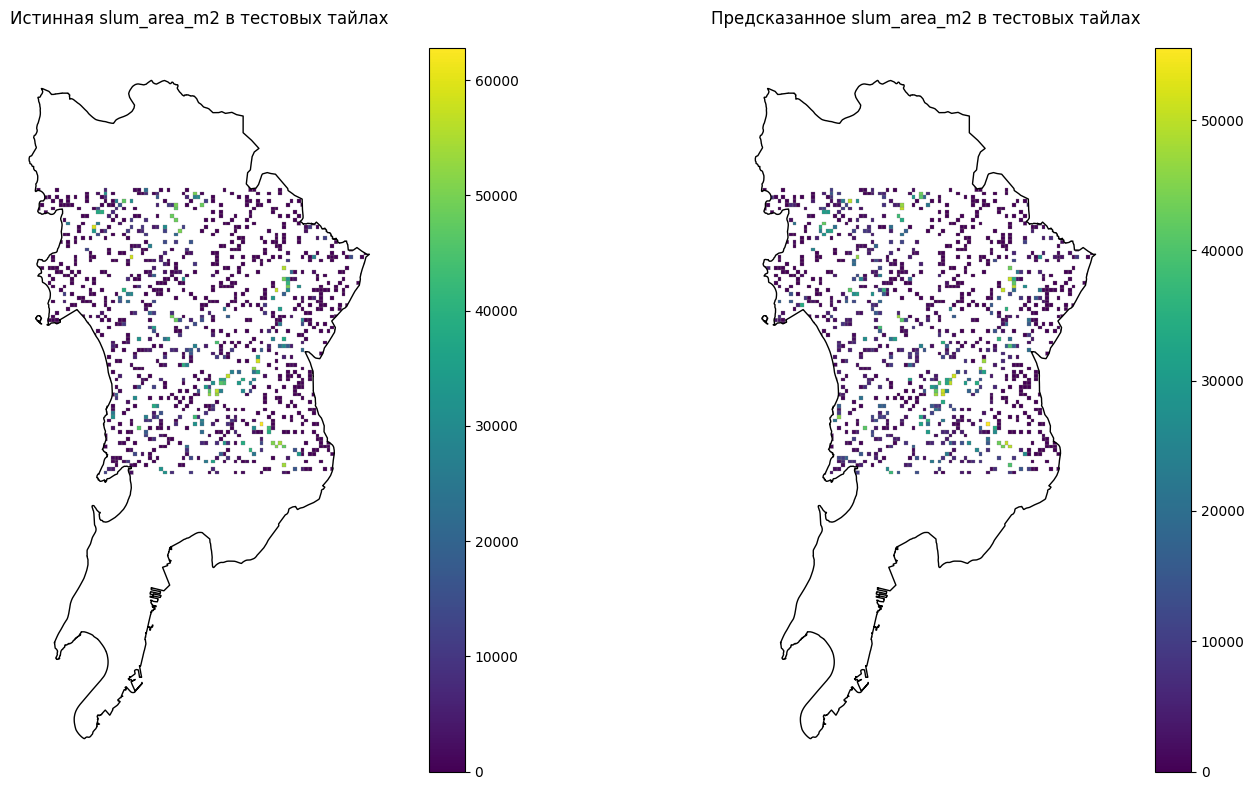

In [447]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# левый: истинные slum_area_m2
test_gdf.plot(
    column="y_test",
    cmap="viridis",
    linewidth=0.2,
    edgecolor="grey",
    legend=True,
    ax=axes[0],
    missing_kwds={"color": "lightgrey"}
)
mumbai_metric.boundary.plot(ax=axes[0], edgecolor='black', linewidth=1)
axes[0].set_title("Истинная slum_area_m2 в тестовых тайлах")
axes[0].axis("off")

# правый: предсказанное slum_area_m2
test_gdf.plot(
    column="y_pred",
    cmap="viridis",
    linewidth=0.2,
    edgecolor="grey",
    legend=True,
    ax=axes[1],
    missing_kwds={"color": "lightgrey"}
)
mumbai_metric.boundary.plot(ax=axes[1], edgecolor='black', linewidth=1)
axes[1].set_title("Предсказанное slum_area_m2 в тестовых тайлах")
axes[1].axis("off")

plt.tight_layout()
plt.show()

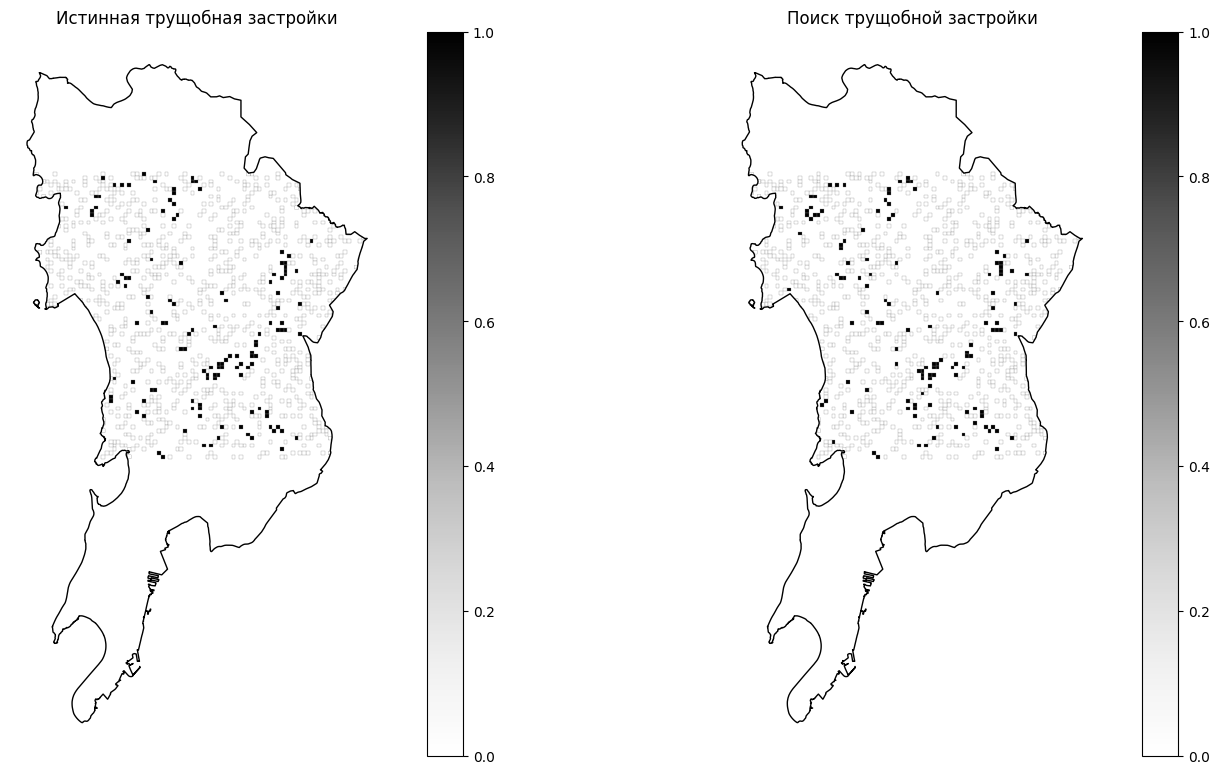

In [448]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# левый: истинные slum_area_m2
test_gdf.plot(
    column="y_test_cl",
    cmap="Greys",
    linewidth=0.2,
    edgecolor="grey",
    legend=True,
    ax=axes[0],
    missing_kwds={"color": "lightgrey"}
)
mumbai_metric.boundary.plot(ax=axes[0], edgecolor='black', linewidth=1)
axes[0].set_title("Истинная трущобная застройки")
axes[0].axis("off")

# правый: предсказанное slum_area_m2
test_gdf.plot(
    column="y_pred_cl",
    cmap="Greys",
    linewidth=0.2,
    edgecolor="grey",
    legend=True,
    ax=axes[1],
    missing_kwds={"color": "lightgrey"}
)
mumbai_metric.boundary.plot(ax=axes[1], edgecolor='black', linewidth=1)
axes[1].set_title("Поиск трущобной застройки")
axes[1].axis("off")

plt.tight_layout()
plt.show()

### Теперь сделаем наконец-то визуализацию. Выделим с помощью индексов NDBI, NDVI, GLCM участки, где есть застройка

(4181, 2288)
(4181, 2288)
(4163, 2276)
Изображение сохранено: Визуализация/Mumbai_buildings_indexes.png


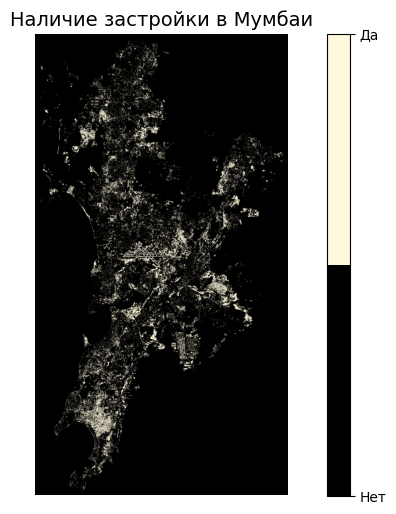

In [489]:
print(ndbi_raster.shape)
print(ndvi_raster.shape)
print(entropy_result.shape)

min_rows = min(ndbi_raster.shape[0], ndvi_raster.shape[0], entropy_result.shape[0])
min_cols = min(ndbi_raster.shape[1], ndvi_raster.shape[1], entropy_result.shape[1])

ndbi_raster_cropped = ndbi_raster[:min_rows, :min_cols]
ndvi_raster_cropped = ndvi_raster[:min_rows, :min_cols]
entropy_result_cropped = entropy_result[:min_rows, :min_cols]

data_filtered = (ndbi_raster_cropped > 0.05) & (ndvi_raster_cropped < 0.1) & (ndvi_raster_cropped > -0.05) & (entropy_result_cropped > 1)
cmap = ListedColormap(['black', '#FFF8DC'])

plt.figure(figsize=(10, 6))
plt.imshow(data_filtered, cmap=cmap)

cbar = plt.colorbar(ticks=[0, 1])
cbar.ax.set_yticklabels(['Нет', 'Да'])

plt.title('Наличие застройки в Мумбаи',
             {'fontsize': 14,'horizontalalignment': 'center'})
plt.axis('off')

output_image = "Визуализация/Mumbai_buildings_indexes.png"
fig.savefig(output_image, dpi=300, bbox_inches='tight')
print(f"Изображение сохранено: {output_image}")

plt.show()

### Теперь пора делать карты
Для этого разберемся с домиками, так как с microsoft слой не на весь город Мумбаи, но в файле `features_prep` мы разобрализ с этой проблемой (добавили домики из OSM)

In [470]:
grid_all_clipped = grid_clipped[['tile_id', 'mean_ndvi', 'mean_ndbi', 'mean_ibi', 'mean_glcm',
       'mean_nightlights', 'slum_area_m2', 'geometry']].copy()

if mumbai_builds_all_clipped.crs != grid_all_clipped.crs:
    mumbai_builds_all_clipped = mumbai_builds_all_clipped.to_crs(grid_all_clipped.crs)

# Рассчитываем полную площадь зданий (в м²)
mumbai_builds_all_clipped["build_area_m2"] = mumbai_builds_all_clipped.geometry.area

# Spatial join: какие здания пересекают каждый тайл?
builds_with_tile = gpd.sjoin(
    mumbai_builds_all_clipped[["geometry", "build_area_m2"]],
    grid_all_clipped[["tile_id", "geometry"]],
    how="inner",
    predicate="intersects"
).drop(columns="index_right")

# Группировка по tile_id для вычисления статистик
builds_stats = builds_with_tile.groupby("tile_id").agg(
    total_builds_count=("build_area_m2", "count"),
    median_build_area=("build_area_m2", "median"),
    count_small_builds=("build_area_m2", lambda x: np.sum(x <= 40))
).reset_index()

# Добавляем полученные статистики в grid_all_clipped
grid_all_clipped = grid_all_clipped.set_index("tile_id")
builds_stats = builds_stats.set_index("tile_id")

grid_all_clipped["total_builds_count"] = builds_stats["total_builds_count"].fillna(0).astype(int)
grid_all_clipped["median_build_area_m2"] = builds_stats["median_build_area"].fillna(0)
grid_all_clipped["count_small_builds"] = builds_stats["count_small_builds"].fillna(0).astype(int)

# Рассчитываем процент зданий < 40 м²
grid_all_clipped["pct_builds_less_40m2"] = np.where(
    grid_all_clipped["total_builds_count"] > 0,
    grid_all_clipped["count_small_builds"] / grid_all_clipped["total_builds_count"],
    0.0
)

# Рассчитываем процент площади тайла, занятой зданиями
intersections = gpd.overlay(
    grid_all_clipped.reset_index()[["tile_id", "geometry"]],
    mumbai_builds_all_clipped[["geometry"]],
    how="intersection"
)
intersections["intersection_area"] = intersections.geometry.area
area_per_tile = intersections.groupby("tile_id")["intersection_area"].sum().reset_index()

# Добавляем процент занятости тайла
tile_area = 250 * 250
area_per_tile = area_per_tile.set_index("tile_id")
grid_all_clipped["builds_area_m2"] = area_per_tile["intersection_area"].fillna(0)
grid_all_clipped["pct_tile_built_area"] = grid_all_clipped["builds_area_m2"] / tile_area

grid_all_clipped = grid_all_clipped.reset_index(drop=False)
grid_all_clipped.to_file("mumbai_aggregated_tiles_with_all_builds.geojson", driver="GeoJSON", encoding="utf-8")

grid_all_clipped.head()

C:\Users\Mariia\AppData\Local\Temp\ipykernel_30980\4046990126.py:41: UserWarning:

`keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries



,tile_id,mean_ndvi,mean_ndbi,mean_ibi,mean_glcm,mean_nightlights,slum_area_m2,geometry,total_builds_count,median_build_area_m2,count_small_builds,pct_builds_less_40m2,builds_area_m2,pct_tile_built_area
0,0,0.173124,0.104725,501.669037,2.529886,1.945000,0.0,"POLYGON ((8101674.331 2180954.992, 8101674.331...",NaN,NaN,NaN,0.0,NaN,NaN
1,1,0.184896,0.095505,-394.081146,1.562152,1.891250,0.0,"POLYGON ((8101674.331 2181204.992, 8101674.331...",NaN,NaN,NaN,0.0,NaN,NaN
2,2,0.244440,0.051286,-0.108527,1.009415,2.045961,0.0,"POLYGON ((8101674.331 2181454.992, 8101674.331...",NaN,NaN,NaN,0.0,NaN,NaN
3,3,0.280680,0.001981,-7.426566,1.354634,2.121068,0.0,"POLYGON ((8101674.331 2181704.992, 8101674.331...",NaN,NaN,NaN,0.0,NaN,NaN
4,4,0.171637,0.052120,3.714300,2.072296,2.545000,0.0,"POLYGON ((8101674.331 2181704.992, 8101638.544...",1.0,88.308308,0.0,0.0,3.633519,0.000058


In [473]:
grid_all_clipped = grid_all_clipped.fillna(0)

Изображение сохранено: Визуализация/Mumbai_slums_area.png


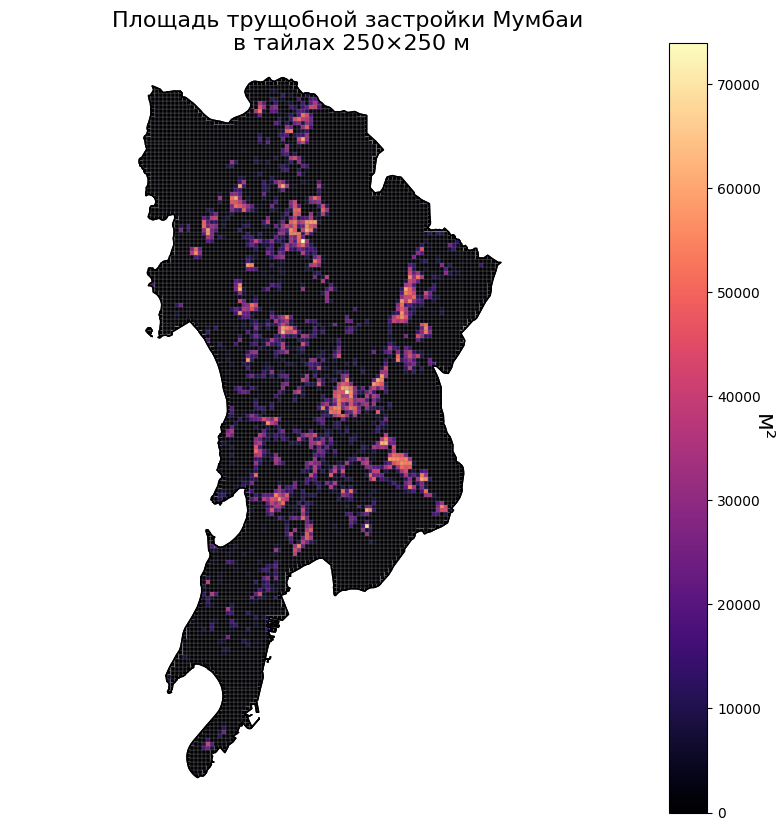

In [528]:
fig, ax = plt.subplots(figsize=(10, 10))
grid_all_clipped.plot(
    column='slum_area_m2',
    cmap='magma',
    legend=True,
    edgecolor='grey',
    linewidth=0.2,
    ax=ax,
    missing_kwds={'color': 'lightgrey'}
)
mumbai_metric.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
ax.set_title('Площадь трущобной застройки Мумбаи \nв тайлах 250×250 м',
             {'fontsize': 16,'horizontalalignment': 'center'},loc = 'center', y =0.98, x =0.55)
mumbai_metric.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
cbar = ax.get_figure().axes[-1]
cbar.set_ylabel('м²', rotation=270, labelpad=10, loc = 'center', fontdict = {'fontsize': 17})
ax.axis('equal')
ax.axis('off')

output_image = "Визуализация/Mumbai_slums_area.png"
fig.savefig(output_image, dpi=300, bbox_inches='tight')
print(f"Изображение сохранено: {output_image}")

plt.show()

Изображение сохранено: Визуализация/Mumbai_slums_yes-no.png


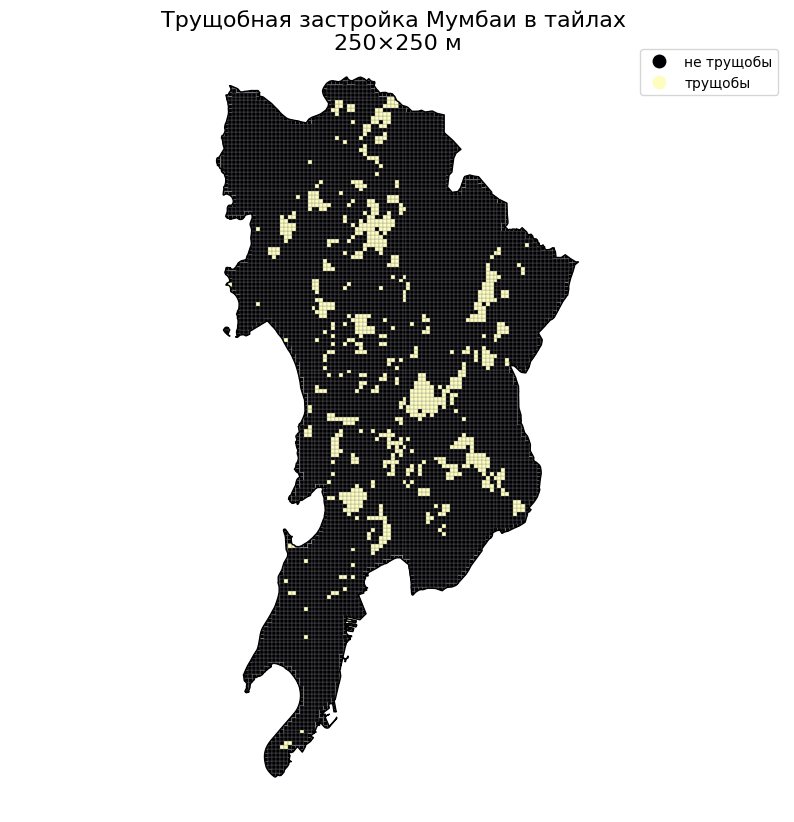

In [527]:
fig, ax = plt.subplots(figsize=(10, 10))
grid_clipped.plot(
    column='slums',
    cmap='magma',
    legend=True,
    edgecolor='grey',
    linewidth=0.2,
    ax=ax,
    missing_kwds={'color': 'lightgrey'}
)
mumbai_metric.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
ax.set_title('Трущобная застройка Мумбаи в тайлах \n250×250 м',
             {'fontsize': 16,'horizontalalignment': 'center'},loc = 'center', y =0.98)
leg = ax.get_legend()
for txt in leg.get_texts():
    if txt.get_text() == 'False':
        txt.set_text('не трущобы')
    elif txt.get_text() == 'True':
        txt.set_text('трущобы')
ax.axis('equal')
ax.axis('off')

output_image = "Визуализация/Mumbai_slums_yes-no.png"
fig.savefig(output_image, dpi=300, bbox_inches='tight')
print(f"Изображение сохранено: {output_image}")

plt.show()

Изображение сохранено: Визуализация/Mumbai_buildings_area.png


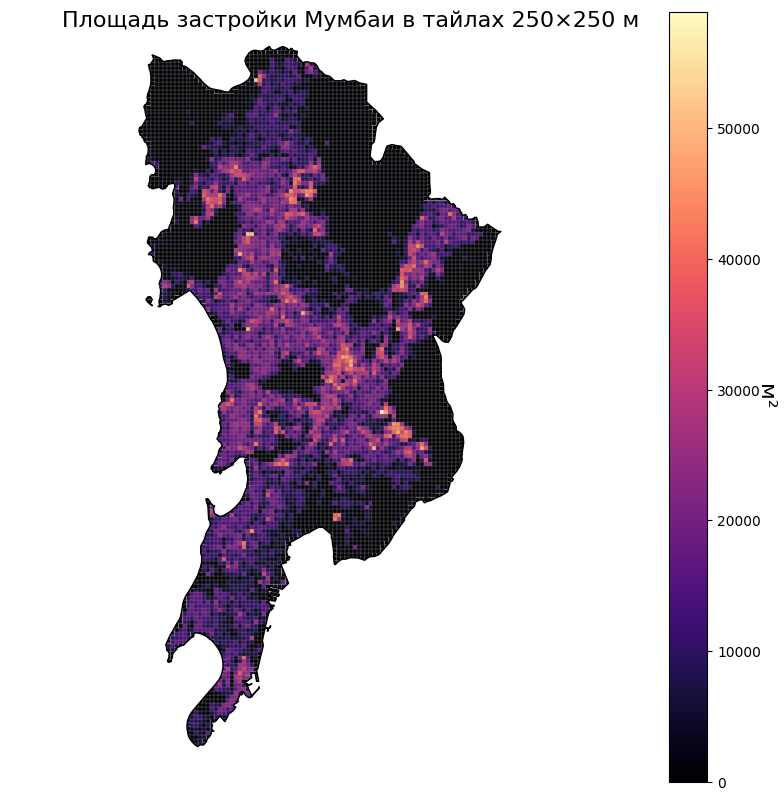

In [529]:
fig, ax = plt.subplots(figsize=(10, 10))
grid_all_clipped.plot(
    column='builds_area_m2',
    cmap='magma',
    legend=True,
    edgecolor='grey',
    linewidth=0.2,
    ax=ax,
    missing_kwds={'color': 'lightgrey'}
)
mumbai_metric.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
ax.set_title('Площадь застройки Мумбаи в тайлах 250×250 м',
             {'fontsize': 16,'horizontalalignment': 'center'},loc = 'center', y =0.97, x =0.55)
cbar = ax.get_figure().axes[-1]
cbar.set_ylabel('м²', rotation=270, labelpad=10, loc = 'center', fontdict = {'fontsize': 16})
ax.axis('equal')
ax.axis('off')

output_image = "Визуализация/Mumbai_buildings_area.png"
fig.savefig(output_image, dpi=300, bbox_inches='tight')
print(f"Изображение сохранено: {output_image}")

plt.show()

### Микрорайоны Мумбаи

In [511]:
mumbai_wards

,gid,name,geometry
0,1,A,"MULTIPOLYGON (((72.84025 18.94881, 72.8403 18...."
1,2,B,"MULTIPOLYGON (((72.84456 18.96342, 72.84461 18..."
2,3,C,"MULTIPOLYGON (((72.83198 18.96174, 72.83197 18..."
3,4,D,"MULTIPOLYGON (((72.81873 18.96901, 72.81878 18..."
4,5,E,"MULTIPOLYGON (((72.84677 18.98183, 72.84658 18..."
5,6,F/S,"MULTIPOLYGON (((72.85625 19.01059, 72.8563 19...."
6,7,G/S,"MULTIPOLYGON (((72.82689 19.01942, 72.82691 19..."
7,8,F/N,"MULTIPOLYGON (((72.87091 19.05119, 72.87103 19..."
8,9,G/N,"MULTIPOLYGON (((72.86699 19.05237, 72.86738 19..."
9,10,N,"MULTIPOLYGON (((72.9167 19.10911, 72.91659 19...."


In [512]:
mumbai_wards = mumbai_wards.to_crs(grid_all_clipped.crs)
grid_with_mumbai_wards = gpd.sjoin(
    grid_all_clipped[['builds_area_m2', 'slum_area_m2', 'geometry']],
    mumbai_wards[['name', 'geometry']],
    how='right',
    predicate='within'
).fillna(0)

sum_agg = (
    grid_with_mumbai_wards
    .groupby('name')[['builds_area_m2', 'slum_area_m2']]
    .sum()
    .reset_index()
)

mumbai_wards_aggregated = mumbai_wards.merge(
    sum_agg,
    on='name',
    how='left'
)
mumbai_wards_aggregated['area'] = mumbai_wards_aggregated.geometry.area
mumbai_wards_aggregated['builds/area'] = mumbai_wards_aggregated['builds_area_m2'] / mumbai_wards_aggregated['area']
mumbai_wards_aggregated['slums/area'] = mumbai_wards_aggregated['slum_area_m2'] / mumbai_wards_aggregated['area']
mumbai_wards_aggregated['slums/all_builds'] = mumbai_wards_aggregated['slum_area_m2'] / (mumbai_wards_aggregated['builds_area_m2'] + mumbai_wards_aggregated['slum_area_m2'])
mumbai_wards_aggregated = mumbai_wards_aggregated.fillna(0)

mumbai_wards_aggregated.to_file("mumbai_wards_aggregated.geojson", driver='GeoJSON')
mumbai_wards_aggregated.to_file("mumbai_wards_aggregated.shp")

C:\Users\Mariia\AppData\Local\Temp\ipykernel_30980\658563821.py:28: UserWarning:

Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.

D:\Users\Mariia\anaconda\envs\myenv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning:

Normalized/laundered field name: 'builds_area_m2' to 'builds_are'

D:\Users\Mariia\anaconda\envs\myenv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning:

Normalized/laundered field name: 'slum_area_m2' to 'slum_area_'

D:\Users\Mariia\anaconda\envs\myenv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning:

Normalized/laundered field name: 'builds/area' to 'builds/are'

D:\Users\Mariia\anaconda\envs\myenv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning:

Normalized/laundered field name: 'slums/all_builds' to 'slums/all_'



Изображение сохранено: Визуализация/Mumbai_wards_slums.png


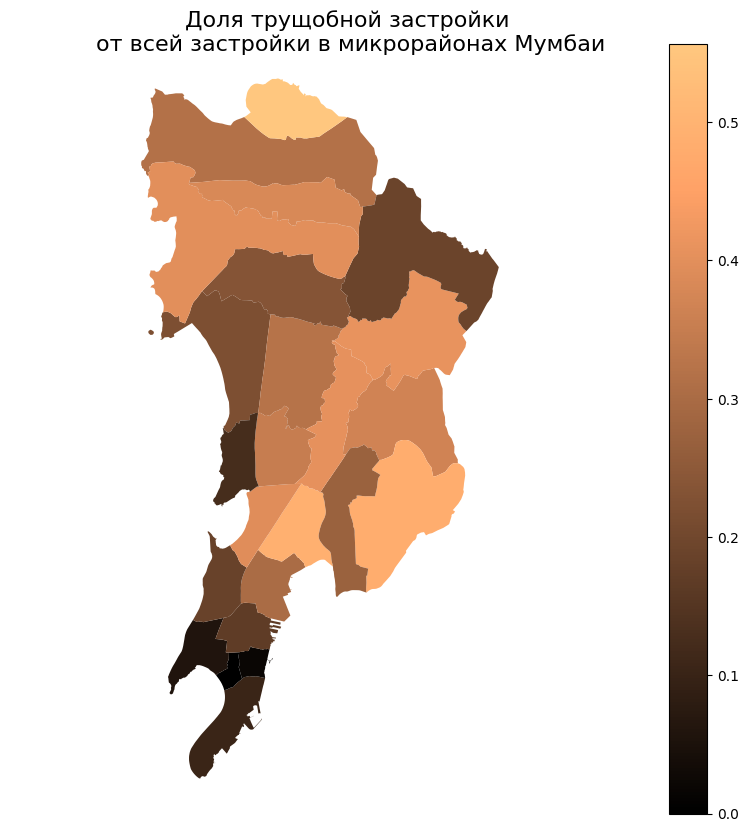

In [521]:
fig, ax = plt.subplots(figsize=(10, 10))
mumbai_wards_aggregated.plot(
    column='slums/all_builds',
    cmap='copper', #gist_yarg'
    legend=True,
    # edgecolor='black',
    # linewidth=0.1,
    ax=ax,
    # missing_kwds={'color': 'lightgrey'}
)
# mumbai_wards_aggregated.boundary.plot(ax=ax, edgecolor='grey', linewidth=0.1)
ax.set_title('Доля трущобной застройки \nот всей застройки в микрорайонах Мумбаи',
             {'fontsize': 16,'horizontalalignment': 'center'},loc = 'center', y =0.98, x =0.55)
ax.axis('equal')
ax.axis('off')

output_image = "Визуализация/Mumbai_wards_slums.png"
fig.savefig(output_image, dpi=300, bbox_inches='tight')
print(f"Изображение сохранено: {output_image}")

plt.show()

In [522]:
# Обрезаем красивую цветовую шкалу, чтобы сверху не было белого, выглядит как пробел в дыннх
base = plt.get_cmap('gist_heat')
trunc = LinearSegmentedColormap.from_list(
    'trunc_gist_heat',
    base(np.linspace(0, 0.9, 256))
)

Изображение сохранено: Визуализация/Mumbai_wards_all_buildings.png


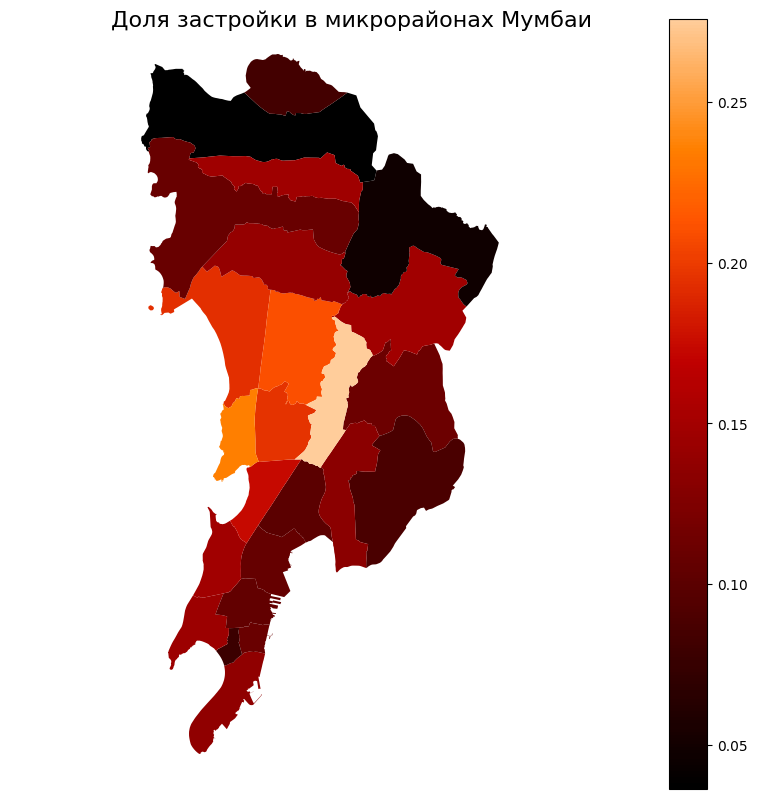

In [523]:
fig, ax = plt.subplots(figsize=(10, 10))
mumbai_wards_aggregated.plot(
    column='builds/area',
    cmap=trunc,
    legend=True,
    # edgecolor='grey',
    # linewidth=0.2,
    ax=ax,
    missing_kwds={'color': 'lightgrey'}
)

# bangalore_wards_aggregated.boundary.plot(ax=ax, edgecolor='black', linewidth=0.1)
ax.set_title('Доля застройки в микрорайонах Мумбаи',
             {'fontsize': 16,'horizontalalignment': 'center'},loc = 'center', y =0.98, x =0.55)
ax.axis('equal')
ax.axis('off')

output_image = "Визуализация/Mumbai_wards_all_buildings.png"
fig.savefig(output_image, dpi=300, bbox_inches='tight')
print(f"Изображение сохранено: {output_image}")

plt.show()

Изображение сохранено: Визуализация/Mumbai_wards_slums_20.png


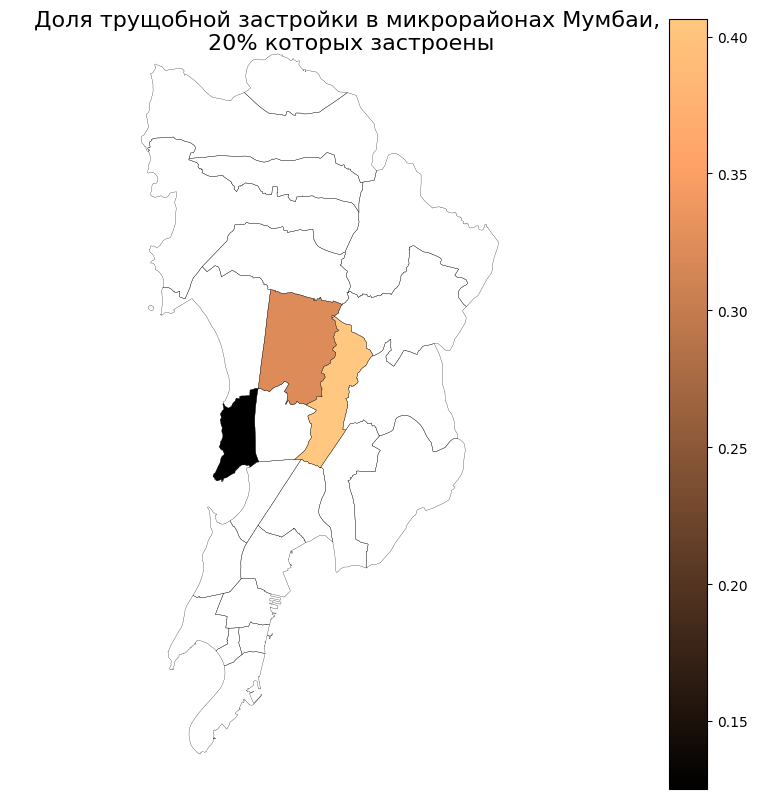

In [524]:
mumbai_wards_filtered = mumbai_wards_aggregated[mumbai_wards_aggregated['builds/area']>0.2]
fig, ax = plt.subplots(figsize=(10, 10))
mumbai_wards_filtered.plot(
    column='slums/all_builds',
    cmap='copper',
    legend=True,
    # edgecolor='grey',
    # linewidth=0.2,
    ax=ax,
    missing_kwds={'color': 'lightgrey'}
)
mumbai_wards_aggregated.boundary.plot(ax=ax, edgecolor='black', linewidth=0.2)
ax.set_title('Доля трущобной застройки в микрорайонах Мумбаи, \n20% которых застроены',
             {'fontsize': 16,'horizontalalignment': 'center'},loc = 'center', y =0.95, x =0.55)
ax.axis('equal')
ax.axis('off')

output_image = "Визуализация/Mumbai_wards_slums_20.png"
fig.savefig(output_image, dpi=300, bbox_inches='tight')
print(f"Изображение сохранено: {output_image}")

plt.show()